In [94]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as cx
import momepy
import networkx as nx
import shapely

## Bewerken Snelheden

In [ ]:
wegen_geometry = gpd.read_file('./wegen/Snelheden.shp')
print(wegen_geometry)
wegen_geometry_wm = wegen_geometry.to_crs(epsg=3857)

In [ ]:
is_rijksweg = wegen_geometry['WEGBEHSRT'] == 'R'
is_nweg = wegen_geometry['WEGBEHSRT'] == 'P'
is_friesland = wegen_geometry['PVE_CODE'] == 'FR'

plt.figure(figsize=(8, 8), dpi=80)

ax1 = wegen_geometry_wm[is_rijksweg & is_friesland].plot(column="MAXSHD", color="red", linewidth=2, edgecolor=".4", figsize=(15,15), label='State roads')
wegen_geometry_wm[is_nweg & is_friesland].plot(column="MAXSHD", color="darkblue", linewidth=0.8, ax=ax1, edgecolor=".4", label='Provincial Roads')

cx.add_basemap(ax1)
ax1.set_axis_off()
plt.legend(prop={'size': 20})
# plt.savefig('./frieslandimg.png', dpi=200)

In [ ]:
# wegen_geometry_wm[is_friesland & (is_rijksweg | is_nweg)].to_file('./friesland.shp')

## Verwerken Friesland

Zie vanaf dit punt analyse 2, dit is experimenteren

In [95]:
# duurt een minuutje
friesland_wegen = gpd.read_file('./friesland.shp').to_crs(epsg=3857)

# combine nearby points
friesland_wegen.geometry = momepy.close_gaps(friesland_wegen, 3)

In [96]:
graph = momepy.gdf_to_nx(friesland_wegen, approach="primal", length='LENGTE')
graph = nx.Graph(graph)
print(f"{len(graph.nodes)=} {len(graph.edges)=}")

len(graph.nodes)=4121 len(graph.edges)=4606


In [97]:
# e = list(graph.edges)[0]

for e in graph.edges:
    # graph.add_edge(e[0], e[1], length=graph.get_edge_data(*e)['LENGTE'])
    graph[e[0]][e[1]]['length'] = float(graph[e[0]][e[1]]['LENGTE'])
    print(graph.get_edge_data(*e))

{'WVK_ID': 345518066, 'WVK_BEGDAT': Timestamp('2022-03-01 00:00:00'), 'NWB_VERSIE': Timestamp('2024-01-01 00:00:00'), 'PVE_CODE': 'FR', 'GME_ID': 1900, 'GME_NAAM': 'Súdwest-Fryslân', 'WPSNAAM': 'Sneek', 'STT_NAAM': 'SNEEK-CENTRUM 21', 'WEGNUMMER': '007', 'WEGBEHSRT': 'R', 'WEGBEHCODE': '199', 'WEGBEHNAAM': 'NN District West', 'LENGTE': 27.313436343572015, 'BST_CODE': 'PST', 'MAXSHD': '80', 'DAT_MAXSHD': '2022/03/01', 'BEGINTIJD': nan, 'EINDTIJD': nan, 'MAXSHD_ALT': nan, 'VAN': 0, 'NAAR': 16, 'MAXSHD_STR': nan, 'MAXSHD_ADV': nan, 'KENM_RICHT': 'H', 'FK_VELD1': '034551806620220301', 'BETRWBHEID': '100%', 'geometry': <LINESTRING (629455.19 6987084.986, 629481.412 6987077.341)>, 'length': 27.313436343572015}
{'WVK_ID': 345519122, 'WVK_BEGDAT': Timestamp('2022-03-01 00:00:00'), 'NWB_VERSIE': Timestamp('2024-01-01 00:00:00'), 'PVE_CODE': 'FR', 'GME_ID': 1900, 'GME_NAAM': 'Súdwest-Fryslân', 'WPSNAAM': 'Sneek', 'STT_NAAM': 'SNEEK-CENTRUM 21', 'WEGNUMMER': '007', 'WEGBEHSRT': 'R', 'WEGBEHCODE':

In [98]:
# nx.draw(graph, {n: [n[0], n[1]] for n in list(graph.nodes)}, node_size=10)

In [101]:
def remove_node_reattached(node, g):
    edges = list(g.edges(node))

    if len(edges) != 2:
        # print('warning: node passed with not-2 degree, ignored')
        return
    
    a1, b1 = edges[0]
    a2, b2 = edges[1]
    
    e1 = a1 if a1 != node else b1
    e2 = a2 if a2 != node else b2

    # create new edge with new geometry (straight line)
    # TODO: if possible, reconstruct geometry using old linestring
    g.add_edge(e1, e2, 
               length=g[a1][b1]['length'] + g[a2][b2]['length'],
               wegnr=g[a1][b1]['wegnr'],
               geometry=shapely.LineString([e1, e2]))
    # g.add_edge(e1, e2)
    g.remove_node(node)

def remove_degree2(new, original):
    # all degree 2 nodes to be removed
    to_remove = [node for node, degree in original.degree if degree == 2]
    for node_remove in to_remove:
        remove_node_reattached(node_remove, new)

simplified_graph = graph.subgraph(max(nx.connected_components(graph), key=len)).copy()

# only store WEGNR and length as attributes
for e in simplified_graph.edges:
    data = simplified_graph.get_edge_data(*e)
    wegnr = data['WEGNUMMER']
    length = data['length']
    geometry = data['geometry']
    data.clear()
    nx.set_edge_attributes(simplified_graph, {e: {'wegnr': wegnr, 'length': length, 'geometry': geometry }})

remove_degree2(simplified_graph, graph)

# remove self loops which may have reappeared
# simplified_graph.remove_edges_from(list(nx.selfloop_edges(simplified_graph)))

# combine intersections
# consol_graph = momepy.consolidate_intersections(nx.MultiGraph(simplified_graph), 1000)

print(f"{len(simplified_graph.nodes)=} {len(simplified_graph.edges)=}")

len(simplified_graph.nodes)=1621 len(simplified_graph.edges)=2081


In [93]:
simplified_graph.edges(keys=True)

TypeError: OutEdgeView.__call__() got an unexpected keyword argument 'keys'

In [69]:
(points, lines) = momepy.nx_to_gdf(simplified_graph)
lines.to_file("./wegengraaf/lines.shp")
points.to_file("./wegengraaf/points.shp")

C:\Users\Alexander\AppData\Local\Temp\ipykernel_928\362694449.py:3: FutureWarning: Class based API like `momepy.CircularCompactness` is deprecated. Replace it with `momepy.circular_compactness` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  circom_serie = momepy.CircularCompactness(polys).series


<Axes: >

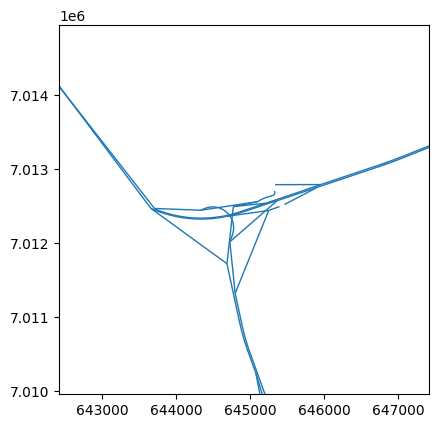

In [87]:
(lines, edges) = momepy.nx_to_gdf(simplified_graph)
polys = gpd.GeoDataFrame(geometry=list(shapely.ops.polygonize(edges.geometry)), crs=edges.crs)
circom_serie = momepy.CircularCompactness(polys).series
polys.loc[:, "circom"] = circom_serie

ax = plt.subplot()

X = 644917
Y = 7012457

ax.set_xlim(X-2500, X+2500)
ax.set_ylim(Y-2500, Y+2500)

# polys.plot(ax=ax, column="circom", cmap="PiYG")
edges.plot(ax=ax, linewidth=1)


In [39]:
# (points, lines) = momepy.nx_to_gdf(graph)
# points.to_file("./wegengraaf/points_bigger.shp")
# lines.to_file("./wegengraaf/lines_bigger.shp")

c:\Users\Alexander\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Field WVK_BEGDAT create as date field, though DateTime requested.
  ogr_write(
c:\Users\Alexander\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Field NWB_VERSIE create as date field, though DateTime requested.
  ogr_write(


(561064.0079558409, 723085.493542376, 6941890.755864199, 7070505.179794088)

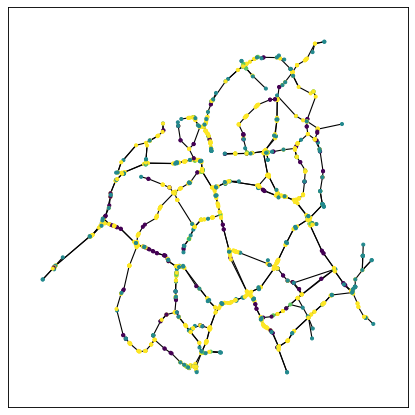

In [72]:
plt.figure(figsize=(5, 5), dpi=80)

#                   0           1          2          3          4          5          6
# node_color_types = ['#ff00ff', '#ff0000', '#000000', '#00ff00', '#0000ff', '#00ffff', '#ffff00']
node_color_types = np.random.randint(0, 0xFFFFFF, 50)
node_color = [node_color_types[deg] for _, deg in simplified_graph.degree]

# ax1 = friesland_wegen.plot(linewidth=0, figsize=(12, 12))
# cx.add_basemap(ax1)

nx.draw(simplified_graph, {n: [n[0], n[1]] for n in list(simplified_graph.nodes)},
        node_size=7, node_color=node_color)


plt.axis("on")

In [19]:
wegnummers = set([graph[e[0]][e[1]]['WEGNUMMER'] for e in graph.edges])

print(wegnummers)

{'N355', 'N928', 'N927', 'N351', 'N359', 'N358', '031', 'N392', '006', 'N388', 'N924', 'N390', 'N357', 'N361', '007', None, 'N919', 'N353', 'N384', 'N383', 'N398', 'N356', 'N917', 'N913', '032', 'N354', 'N369', 'N380', 'N381', 'N910', 'N918', 'N393'}
